##Data Cleaning and Processing of Stroke Prediction Data



This notebook is organized to guide the process of data cleaning and processing of the stroke prediction data. The workflow begins with importing and exploring the dataset, followed by thorough data cleaning and preprocessing, including handling missing values and encoding categorical variables. Multiple imputation strategies for missing BMI values are evaluated, and the cleaned dataset is standardized for model training.

In [211]:
#Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [212]:
#read the data file with pandas

df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [213]:
#describe shape of dataframe

df.shape


(5110, 12)

In [214]:
#check the column names of dataframe

df.columns


Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [215]:
#format the column names of dataframe to ensure consistency (lowercase)

df = df.rename(columns=str.lower)

In [216]:
#describe the information of dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [217]:
#descriptives of columns with numerical values

df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [218]:
#Check the number of values for each column

for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

id: 5110 unique values
gender: 3 unique values
age: 104 unique values
hypertension: 2 unique values
heart_disease: 2 unique values
ever_married: 2 unique values
work_type: 5 unique values
residence_type: 2 unique values
avg_glucose_level: 3979 unique values
bmi: 418 unique values
smoking_status: 4 unique values
stroke: 2 unique values


In [219]:
#Check number of duplicate rows

print(f"Duplicate rows: {df.duplicated().sum()}")


Duplicate rows: 0


In [220]:
#Gender with three values - check the frequency

df.gender.value_counts()


,count
gender,
Female,2994
Male,2115
Other,1


In [221]:
#remove data with gender=other

df = df[df.gender != 'Other']

df.gender.value_counts()

,count
gender,
Female,2994
Male,2115


##Compare means of different variables for stroke and non-stroke respondents

In [222]:
#drop id

df = df.drop('id', axis=1)

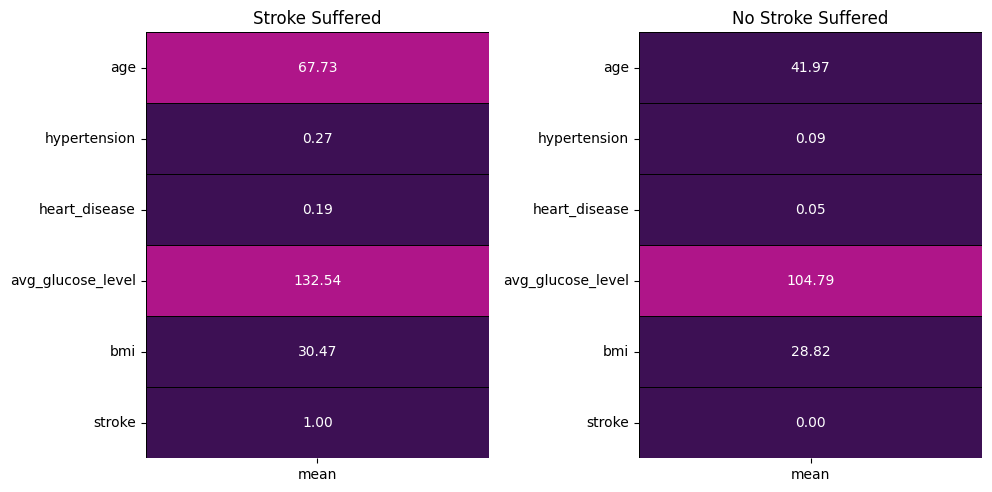

In [223]:
# Separate statistics for stroke and no stroke
stroke = df[df['stroke'] == 1].describe().T
no_stroke = df[df['stroke'] == 0].describe().T

# Define a proper colormap
from matplotlib.colors import ListedColormap
colors = ListedColormap(['#3D1054', '#AF1589'])

# Create subplots with proper figsize for 2 plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Heatmap for stroke
sns.heatmap(stroke[['mean']], annot=True, cmap=colors, linewidths=0.4,
            linecolor='black', cbar=False, fmt='.2f', ax=ax[0])
ax[0].set_title('Stroke Suffered')

# Heatmap for no stroke
sns.heatmap(no_stroke[['mean']], annot=True, cmap=colors, linewidths=0.4,
            linecolor='black', cbar=False, fmt='.2f', ax=ax[1])
ax[1].set_title('No Stroke Suffered')

plt.tight_layout(pad=1)
plt.show()


In [224]:
categorical_cols = ['gender', 'ever_married', 'work_type', 'residence_type', 'smoking_status']

for col in categorical_cols:
    print(f"Percentage of stroke for {col}:")
    # Group by the current categorical column and stroke, then unstack to get counts
    stroke_counts = df.groupby([col, 'stroke']).size().unstack(fill_value=0)
    # Calculate the percentage of stroke cases within each category
    stroke_percentages = stroke_counts.apply(lambda x: x / x.sum() * 100, axis=1)
    # Display the percentage for stroke (stroke=1)
    if 1 in stroke_percentages.columns:
        display(stroke_percentages[[1]].rename(columns={1: 'Stroke Percentage (%)'}))
    else:
        print("No stroke cases found in this column.")
    print("-" * 30)

Percentage of stroke for gender:


stroke,Stroke Percentage (%)
gender,
Female,4.709419
Male,5.106383


------------------------------
Percentage of stroke for ever_married:


stroke,Stroke Percentage (%)
ever_married,
No,1.651481
Yes,6.561288


------------------------------
Percentage of stroke for work_type:


stroke,Stroke Percentage (%)
work_type,
Govt_job,5.022831
Never_worked,0.000000
Private,5.095759
Self-employed,7.936508
children,0.291121


------------------------------
Percentage of stroke for residence_type:


stroke,Stroke Percentage (%)
residence_type,
Rural,4.536411
Urban,5.200308


------------------------------
Percentage of stroke for smoking_status:


stroke,Stroke Percentage (%)
smoking_status,
Unknown,3.044041
formerly smoked,7.918552
never smoked,4.756871
smokes,5.323194


------------------------------


##Handling Missing Values of BMI

In [225]:
# check missing values

df.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
residence_type,0
avg_glucose_level,0
bmi,201
smoking_status,0


In [226]:
df_stroke=df.copy()

In [227]:
# Impute missing 'bmi' values with the median for each stroke group
df_stroke['bmi'] = df_stroke.groupby('stroke')['bmi'].transform(lambda x: x.fillna(x.median()))

# Check for missing values again to confirm imputation
print("Missing values after imputation:")
print(df_stroke.isnull().sum())

Missing values after imputation:
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [228]:
#Show the descriptives of bmi for different gender

print("Descriptive statistics of BMI by Gender:")
print(df_stroke.groupby('stroke')['bmi'].mean())
print(df_stroke.groupby('stroke')['bmi'].median())


Descriptive statistics of BMI by Gender:
stroke
0    28.797119
1    30.347390
Name: bmi, dtype: float64
stroke
0    28.0
1    29.7
Name: bmi, dtype: float64


##BMI Binning

In [229]:
# BMI Binning
df_stroke['bmi_category'] = pd.cut(
    df_stroke['bmi'],
    bins=[0, 18.5, 24.9, 29.9, df_stroke['bmi'].max()],
    labels=['Underweight', 'Normal', 'Overweight', 'Obese'],
    right=False
)

bmi_stroke_counts = df_stroke.groupby(['bmi_category', 'stroke']).size().unstack(fill_value=0)
bmi_stroke_percentages = bmi_stroke_counts.apply(lambda x: x / x.sum() * 100, axis=1)
display(bmi_stroke_percentages)

stroke,0,1
bmi_category,,
Underweight,99.703264,0.296736
Normal,97.119342,2.880658
Overweight,93.047796,6.952204
Obese,94.807198,5.192802


In [230]:
print(df_stroke.isnull().sum())

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
bmi_category         1
dtype: int64


##Encode categorical features.

In [231]:
df_stroke.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_category
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,Obese
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.7,never smoked,1,Overweight
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,Obese
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,Obese
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,Normal


In [232]:
df_stroke = pd.get_dummies(df_stroke, columns=['gender', 'ever_married', 'work_type', 'residence_type', 'smoking_status', 'bmi_category'])
df_stroke.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,...,residence_type_Rural,residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,bmi_category_Underweight,bmi_category_Normal,bmi_category_Overweight,bmi_category_Obese
0,67.0,0,1,228.69,36.6,1,False,True,False,True,...,False,True,False,True,False,False,False,False,False,True
1,61.0,0,0,202.21,29.7,1,True,False,False,True,...,True,False,False,False,True,False,False,False,True,False
2,80.0,0,1,105.92,32.5,1,False,True,False,True,...,True,False,False,False,True,False,False,False,False,True
3,49.0,0,0,171.23,34.4,1,True,False,False,True,...,False,True,False,False,False,True,False,False,False,True
4,79.0,1,0,174.12,24.0,1,True,False,False,True,...,True,False,False,False,True,False,False,True,False,False


##Normalize or scale numerical features

In [233]:
# Drop the 'bmi' column from df_stroke
df_stroke = df_stroke.drop('bmi', axis=1)

# Display the first few rows to verify the change
display(df_stroke.head())

,age,hypertension,heart_disease,avg_glucose_level,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,...,residence_type_Rural,residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,bmi_category_Underweight,bmi_category_Normal,bmi_category_Overweight,bmi_category_Obese
0,67.0,0,1,228.69,1,False,True,False,True,False,...,False,True,False,True,False,False,False,False,False,True
1,61.0,0,0,202.21,1,True,False,False,True,False,...,True,False,False,False,True,False,False,False,True,False
2,80.0,0,1,105.92,1,False,True,False,True,False,...,True,False,False,False,True,False,False,False,False,True
3,49.0,0,0,171.23,1,True,False,False,True,False,...,False,True,False,False,False,True,False,False,False,True
4,79.0,1,0,174.12,1,True,False,False,True,False,...,True,False,False,False,True,False,False,True,False,False


In [234]:
#normalize numerical data

from sklearn.preprocessing import StandardScaler

# Select numerical features to normalize
numerical_features = ['age', 'avg_glucose_level']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the numerical data and transform the data
df_stroke[numerical_features] = scaler.fit_transform(df[numerical_features])

df_stroke.head()


,age,hypertension,heart_disease,avg_glucose_level,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,...,residence_type_Rural,residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,bmi_category_Underweight,bmi_category_Normal,bmi_category_Overweight,bmi_category_Obese
0,1.051242,0,1,2.706450,1,False,True,False,True,False,...,False,True,False,True,False,False,False,False,False,True
1,0.785889,0,0,2.121652,1,True,False,False,True,False,...,True,False,False,False,True,False,False,False,True,False
2,1.626174,0,1,-0.004867,1,False,True,False,True,False,...,True,False,False,False,True,False,False,False,False,True
3,0.255182,0,0,1.437473,1,True,False,False,True,False,...,False,True,False,False,False,True,False,False,False,True
4,1.581949,1,0,1.501297,1,True,False,False,True,False,...,True,False,False,False,True,False,False,True,False,False


In [235]:
missing = df_stroke.isnull().sum()
print(missing)

age                               0
hypertension                      0
heart_disease                     0
avg_glucose_level                 0
stroke                            0
gender_Female                     0
gender_Male                       0
ever_married_No                   0
ever_married_Yes                  0
work_type_Govt_job                0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
residence_type_Rural              0
residence_type_Urban              0
smoking_status_Unknown            0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
bmi_category_Underweight          0
bmi_category_Normal               0
bmi_category_Overweight           0
bmi_category_Obese                0
dtype: int64


###Split Training and Testing + SMOTE to balance the sample

In [251]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE # Import SMOTE

# Separate features and target
X = df_stroke.drop('stroke', axis=1)
y = df_stroke['stroke']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Encode categorical features after splitting and imputation
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)


print("Before SMOTE:")
print(y_train.value_counts())

Before SMOTE:
stroke
0    3888
1     199
Name: count, dtype: int64


In [252]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("After SMOTE:")
print(y_train_res.value_counts())

After SMOTE:
stroke
0    3888
1    3888
Name: count, dtype: int64


In [268]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

# Initialize the Logistic Regression model
logistic_model_smote = LogisticRegression(random_state=42, max_iter=1000)

# Train the model on the SMOTE-balanced training data
print("Training Logistic Regression model on SMOTE-balanced data...")
logistic_model_smote.fit(X_train_res, y_train_res)

# Evaluate the model on the test set (prediction results)
print("\nPrediction Results on Test Set:")
y_pred_smote = logistic_model_smote.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_smote))
print("\nClassification Report:\n", classification_report(y_test, y_pred_smote))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_smote))

# Perform cross-validation on the SMOTE-balanced training data (validation results)
# Note: Cross-validation is typically done on the original training data before SMOTE
# to get a realistic estimate of performance on unseen data.
# However, if you specifically want validation on the SMOTE data, here is how:
print("\nValidation Results (Cross-Validation on SMOTE-balanced Training Data):")
cv_scores = cross_val_score(logistic_model_smote, X_train_res, y_train_res, cv=5) # 5-fold cross-validation
print(f"Cross-validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-validation Accuracy: {cv_scores.mean():.4f}")

Training Logistic Regression model on SMOTE-balanced data...

Prediction Results on Test Set:
Accuracy: 0.913894324853229

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.95       972
           1       0.26      0.40      0.31        50

    accuracy                           0.91      1022
   macro avg       0.61      0.67      0.63      1022
weighted avg       0.93      0.91      0.92      1022


Confusion Matrix:
 [[914  58]
 [ 30  20]]

Validation Results (Cross-Validation on SMOTE-balanced Training Data):
Cross-validation Accuracy Scores: [0.81169666 0.92347267 0.91961415 0.91511254 0.9266881 ]
Mean Cross-validation Accuracy: 0.8993


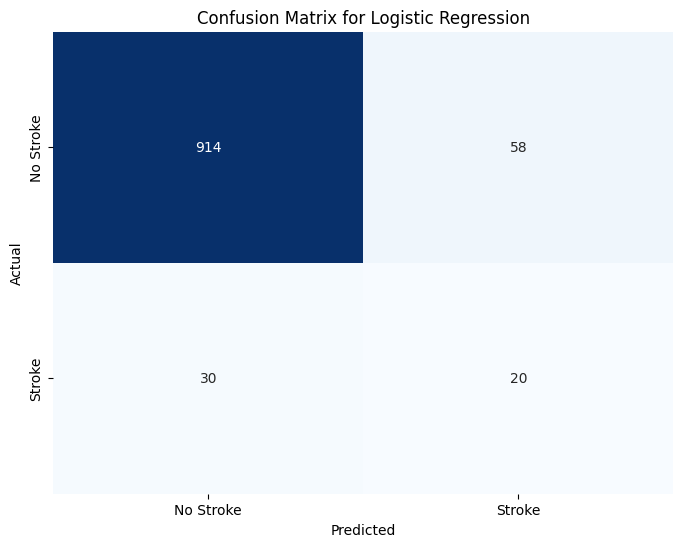

In [262]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_logistic)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [267]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd



# Define the deep learning model
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid') # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
# Using balanced data if SMOTE was applied earlier, otherwise original split
# Assuming you have X_train_res and y_train_res from SMOTE:
if 'X_train_res' in globals() and 'y_train_res' in globals():
    print("Training on SMOTE-balanced data...")
    history = model.fit(X_train_res, y_train_res, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
else:
    print("Training on original data split...")
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)


# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Print classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Training on SMOTE-balanced data...

Test Accuracy: 0.9315
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96       972
           1       0.19      0.12      0.15        50

    accuracy                           0.93      1022
   macro avg       0.57      0.55      0.56      1022
weighted avg       0.92      0.93      0.92      1022


Confusion Matrix:
 [[946  26]
 [ 44   6]]


In [275]:
!pip install keras-tuner

import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Ensure your X_train and y_train data are preprocessed
# (StandardScaler for X and possibly SMOTE for y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --------------------------
# Hypermodel Function
# --------------------------
def build_model(hp):
    model = keras.Sequential()

    # Input layer
    model.add(layers.Dense(
        units=hp.Int('units_input', min_value=64, max_value=512, step=64),
        activation='relu',
        input_shape=(X_train_scaled.shape[1],),
        kernel_initializer='he_normal'
    ))

    # Dropout after input layer
    model.add(layers.Dropout(rate=hp.Float('dropout_input', 0.1, 0.5, step=0.1)))

    # Additional hidden layers
    for i in range(hp.Int('num_layers', 1, 3)):  # 1 to 3 hidden layers
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            activation='relu',
            kernel_initializer='he_normal'
        ))
        model.add(layers.Dropout(rate=hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1)))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
    )

    return model

# --------------------------
# Keras Tuner - RandomSearch
# --------------------------
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Try 10 different hyperparameter combinations
    executions_per_trial=1,
    directory='kt_stroke_model',
    project_name='stroke_prediction'
)

# --------------------------
# Run Hyperparameter Search
# --------------------------
tuner.search(
    X_train_scaled, y_train,
    epochs=50,
    validation_split=0.2,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

# --------------------------
# Get Best Model and Params
# --------------------------
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal number of units in the input layer is {best_hps.get('units_input')}
The optimal learning rate is {best_hps.get('learning_rate')}
""")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train_scaled, y_train,
    epochs=50,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

# Evaluate on test data
loss, accuracy, precision, recall = best_model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Trial 10 Complete [00h 00m 18s]
val_accuracy: 0.9425427913665771

Best val_accuracy So Far: 0.9437652826309204
Total elapsed time: 00h 02m 30s

The optimal number of units in the input layer is 256
The optimal learning rate is 0.0007104601071771186

Epoch 1/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9037 - loss: 0.2838 - precision_3: 0.0383 - recall_3: 0.0177 - val_accuracy: 0.9425 - val_loss: 0.2224 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9465 - loss: 0.1802 - precision_3: 0.1674 - recall_3: 0.0207 - val_accuracy: 0.9413 - val_loss: 0.2010 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9523 - loss: 0.1578 - precision_3: 0.4415 - recall_3: 0.0682 - val_accuracy: 0.9425 - val_loss: 0.2176 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9532 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


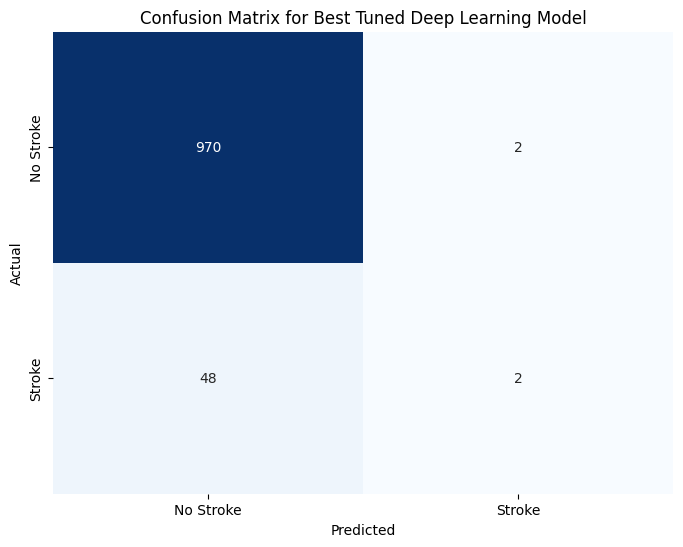

In [277]:
# Make predictions with the best model
y_pred_prob_best = best_model.predict(X_test_scaled)
y_pred_best = (y_pred_prob_best > 0.5).astype("int32")

# Generate the confusion matrix
cm_best = confusion_matrix(y_test, y_pred_best)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Best Tuned Deep Learning Model')
plt.show()

In [265]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize and train the Random Forest model
# Using balanced data if SMOTE was applied earlier
if 'X_train_res' in globals() and 'y_train_res' in globals():
    print("Training Random Forest on SMOTE-balanced data...")
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train_res, y_train_res)
else:
    print("Training Random Forest on original data split...")
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)


# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("\nRandom Forest Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Training Random Forest on SMOTE-balanced data...

Random Forest Model Evaluation:
Accuracy: 0.9187866927592955

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       972
           1       0.12      0.10      0.11        50

    accuracy                           0.92      1022
   macro avg       0.54      0.53      0.53      1022
weighted avg       0.91      0.92      0.92      1022


Confusion Matrix:
 [[934  38]
 [ 45   5]]


In [266]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize and train the KNN model
# Using balanced data if SMOTE was applied earlier
if 'X_train_res' in globals() and 'y_train_res' in globals():
    print("Training KNN on SMOTE-balanced data...")
    knn_model = KNeighborsClassifier()
    knn_model.fit(X_train_res, y_train_res)
else:
    print("Training KNN on original data split...")
    knn_model = KNeighborsClassifier()
    knn_model.fit(X_train, y_train)


# Make predictions on the test set
y_pred_knn = knn_model.predict(X_test)

# Evaluate the model
print("\nKNN Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))

Training KNN on SMOTE-balanced data...

KNN Model Evaluation:
Accuracy: 0.8776908023483366

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.93       972
           1       0.07      0.12      0.09        50

    accuracy                           0.88      1022
   macro avg       0.51      0.52      0.51      1022
weighted avg       0.91      0.88      0.89      1022


Confusion Matrix:
 [[891  81]
 [ 44   6]]


In [269]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

# Initialize and train the Decision Tree model
# Using balanced data if SMOTE was applied earlier
if 'X_train_res' in globals() and 'y_train_res' in globals():
    print("Training Decision Tree on SMOTE-balanced data...")
    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X_train_res, y_train_res)
else:
    print("Training Decision Tree on original data split...")
    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X_train, y_train)


# Make predictions on the test set (prediction results)
print("\nPrediction Results on Test Set:")
y_pred_dt = dt_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

# Perform cross-validation on the SMOTE-balanced training data (validation results)
print("\nValidation Results (Cross-Validation on SMOTE-balanced Training Data):")
cv_scores_dt = cross_val_score(dt_model, X_train_res, y_train_res, cv=5) # 5-fold cross-validation
print(f"Cross-validation Accuracy Scores: {cv_scores_dt}")
print(f"Mean Cross-validation Accuracy: {cv_scores_dt.mean():.4f}")

Training Decision Tree on SMOTE-balanced data...

Prediction Results on Test Set:
Accuracy: 0.8737769080234834

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93       972
           1       0.13      0.28      0.18        50

    accuracy                           0.87      1022
   macro avg       0.55      0.59      0.55      1022
weighted avg       0.92      0.87      0.89      1022


Confusion Matrix:
 [[879  93]
 [ 36  14]]

Validation Results (Cross-Validation on SMOTE-balanced Training Data):
Cross-validation Accuracy Scores: [0.86375321 0.91575563 0.92926045 0.91125402 0.93826367]
Mean Cross-validation Accuracy: 0.9117


In [280]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize and train the SVM model
# Using balanced data if SMOTE was applied earlier
if 'X_train_res' in globals() and 'y_train_res' in globals():
    print("Training SVM on SMOTE-balanced data...")
    svm_model = SVC(random_state=42)
    svm_model.fit(X_train_res, y_train_res)
else:
    print("Training SVM on original data split...")
    svm_model = SVC(random_state=42)
    svm_model.fit(X_train, y_train)


# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
print("\nSVM Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

Training SVM on SMOTE-balanced data...

SVM Model Evaluation:
Accuracy: 0.9295499021526419

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96       972
           1       0.23      0.18      0.20        50

    accuracy                           0.93      1022
   macro avg       0.59      0.57      0.58      1022
weighted avg       0.92      0.93      0.93      1022


Confusion Matrix:
 [[941  31]
 [ 41   9]]


##Use of PCA to do different models

https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-024-05866-8

In [253]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# ------------------------
# Helper Functions
# ------------------------
def PKD(X, y, max_components=None):
    n_features = X.shape[1]
    max_components = max_components if max_components else min(n_features, 10)

    models = {
        'RandomForest': RandomForestClassifier(),
        'SVM': SVC(),
        'NaiveBayes': GaussianNB(),
        'KNN': KNeighborsClassifier(),
        'LogisticRegression': LogisticRegression(max_iter=1000),
        'DecisionTree': DecisionTreeClassifier()
    }

    results = []
    for n in range(1, max_components + 1):
        pca = PCA(n_components=n)
        X_pca = pca.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(
            X_pca, y, test_size=0.2, random_state=42
        )

        row = {'Components': n}
        for model_name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            row[model_name] = accuracy_score(y_test, y_pred)

        results.append(row)

    return pd.DataFrame(results)

def TOP_3_MODELS(df):
    avg_accuracy = df.drop(columns='Components').mean().sort_values(ascending=False)
    return avg_accuracy.head(3)


def plot_accuracy(df):
    plt.figure(figsize=(10, 6))
    for col in df.columns[1:]:  # skip 'Components'
        plt.plot(df['Components'], df[col], marker='o', label=col)

    plt.title("Model Accuracy vs PCA Components")
    plt.xlabel("Number of PCA Components")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# ------------------------
# Main Pipeline
# ------------------------
def run_stroke_model_analysis(df, target_col='stroke', max_components=5):
    """
    Run the full PCA + Model Evaluation pipeline on df_stroke.
    Args:
        df: DataFrame with cleaned stroke data.
        target_col: Target variable (default = 'stroke').
        max_components: Number of PCA components to evaluate.
    Returns:
        Tuple (df_results, top_3_models)
    """
    # 1. Split features and target
    X = df.drop(columns=target_col)
    y = df[target_col]

    # 2. Encode categorical variables (if any)
    X = pd.get_dummies(X, drop_first=True)

    # 3. Apply PCA and evaluate models
    df_results = PKD(X, y, max_components=max_components)

    # 4. Display results
    print("Model Accuracy Results:\n", df_results)
    print("\nTop 3 Models:\n", TOP_3_MODELS(df_results))

    # 5. Plot Accuracy vs PCA Components
    plot_accuracy(df_results)

    return df_results, TOP_3_MODELS(df_results)


Model Accuracy Results:
    Components  RandomForest       SVM  NaiveBayes       KNN  \
0           1      0.910959  0.939335    0.939335  0.938356   
1           2      0.935421  0.939335    0.938356  0.933464   
2           3      0.938356  0.939335    0.939335  0.934442   
3           4      0.936399  0.939335    0.939335  0.936399   
4           5      0.937378  0.939335    0.938356  0.937378   

   LogisticRegression  DecisionTree  
0            0.939335      0.910959  
1            0.939335      0.906067  
2            0.939335      0.894325  
3            0.939335      0.896282  
4            0.939335      0.906067  

Top 3 Models:
 SVM                   0.939335
LogisticRegression    0.939335
NaiveBayes            0.938943
dtype: float64


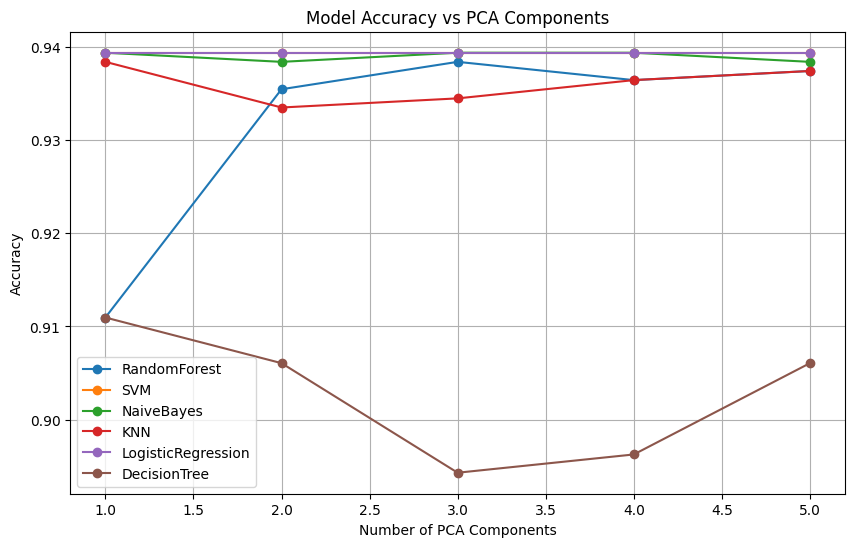

In [254]:
# Assuming df_stroke is already cleaned
df_results, top_3_models = run_stroke_model_analysis(df_stroke, target_col='stroke', max_components=5)


In [255]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

def PKD_with_class1_accuracy(X, y, max_components=None):
    """
    Perform PCA with varying components and evaluate multiple models.
    Returns both overall accuracy and class 1 recall (accuracy for class 1).
    """
    n_features = X.shape[1]
    max_components = max_components if max_components else min(n_features, 10)

    models = {
        'RandomForest': RandomForestClassifier(),
        'SVM': SVC(),
        'NaiveBayes': GaussianNB(),
        'KNN': KNeighborsClassifier(),
        'LogisticRegression': LogisticRegression(max_iter=1000),
        'DecisionTree': DecisionTreeClassifier()
    }

    results = []
    for n in range(1, max_components + 1):
        pca = PCA(n_components=n)
        X_pca = pca.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(
            X_pca, y, test_size=0.2, random_state=42
        )

        row = {'Components': n}
        for model_name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Store both metrics
            row[f'{model_name}_accuracy'] = accuracy_score(y_test, y_pred)
            row[f'{model_name}_class1'] = recall_score(y_test, y_pred, pos_label=1)

        results.append(row)

    return pd.DataFrame(results)


def TOP_3_MODELS(df):
    avg_accuracy = df.drop(columns='Components').mean().sort_values(ascending=False)
    return avg_accuracy.head(3)


def plot_accuracy(df):
    plt.figure(figsize=(10, 6))
    for col in df.columns[1:]:  # skip 'Components'
        plt.plot(df['Components'], df[col], marker='o', label=col)

    plt.title("Model Accuracy vs PCA Components")
    plt.xlabel("Number of PCA Components")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# ------------------------
# Main Pipeline
# ------------------------
def run_stroke_model_analysis(df, target_col='stroke', max_components=5):
    """
    Run the full PCA + Model Evaluation pipeline on df_stroke.
    Args:
        df: DataFrame with cleaned stroke data.
        target_col: Target variable (default = 'stroke').
        max_components: Number of PCA components to evaluate.
    Returns:
        Tuple (df_results, top_3_models)
    """
    # 1. Split features and target
    X = df.drop(columns=target_col)
    y = df[target_col]

    # 2. Encode categorical variables (if any)
    X = pd.get_dummies(X, drop_first=True)

    # 3. Apply PCA and evaluate models
    df_results = PKD(X, y, max_components=max_components)

    # 4. Display results
    print("Model Accuracy Results:\n", df_results)
    print("\nTop 3 Models:\n", TOP_3_MODELS(df_results))

    # 5. Plot Accuracy vs PCA Components
    plot_accuracy(df_results)

    return df_results, TOP_3_MODELS(df_results)


In [256]:
# Separate features and target
X = df_stroke.drop(columns='stroke')
y = df_stroke['stroke']

# Encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Run PKD with class 1 accuracy
df_results = PKD_with_class1_accuracy(X, y, max_components=5)
print(df_results)


   Components  RandomForest_accuracy  RandomForest_class1  SVM_accuracy  \
0           1               0.910959             0.096774      0.939335   
1           2               0.932485             0.000000      0.939335   
2           3               0.937378             0.000000      0.939335   
3           4               0.937378             0.048387      0.939335   
4           5               0.938356             0.064516      0.939335   

   SVM_class1  NaiveBayes_accuracy  NaiveBayes_class1  KNN_accuracy  \
0         0.0             0.939335                0.0      0.938356   
1         0.0             0.938356                0.0      0.933464   
2         0.0             0.939335                0.0      0.934442   
3         0.0             0.939335                0.0      0.936399   
4         0.0             0.938356                0.0      0.937378   

   KNN_class1  LogisticRegression_accuracy  LogisticRegression_class1  \
0    0.000000                     0.939335       

In [278]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

def PKD_with_class1_accuracy(X, y, max_components=None):
    """
    Perform PCA with varying components and evaluate multiple models.
    Returns both overall accuracy and class 1 recall (accuracy for class 1).
    """
    n_features = X.shape[1]
    max_components = max_components if max_components else min(n_features, 10)

    models = {
        'RandomForest': RandomForestClassifier(),
        'SVM': SVC(),
        'NaiveBayes': GaussianNB(),
        'KNN': KNeighborsClassifier(),
        'LogisticRegression': LogisticRegression(max_iter=1000),
        'DecisionTree': DecisionTreeClassifier()
    }

    results = []
    for n in range(1, max_components + 1):
        pca = PCA(n_components=n)
        X_pca = pca.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(
            X_pca, y, test_size=0.2, random_state=42
        )

        row = {'Components': n}
        for model_name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Store both metrics
            row[f'{model_name}_accuracy'] = accuracy_score(y_test, y_pred)
            row[f'{model_name}_class1'] = recall_score(y_test, y_pred, pos_label=1)

        results.append(row)

    return pd.DataFrame(results)


def TOP_3_MODELS(df):
    avg_accuracy = df.drop(columns='Components').mean().sort_values(ascending=False)
    return avg_accuracy.head(3)


def plot_accuracy(df):
    plt.figure(figsize=(10, 6))
    for col in df.columns[1:]:  # skip 'Components'
        plt.plot(df['Components'], df[col], marker='o', label=col)
    plt.title("Model Accuracy and Class 1 Recall vs PCA Components")
    plt.xlabel("Number of PCA Components")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()

def run_stroke_model_analysis(df, target_col='stroke', max_components=5):
    """
    Run the full PCA + Model Evaluation pipeline on df_stroke.
    Args:
        df: DataFrame with cleaned stroke data.
        target_col: Target variable (default = 'stroke').
        max_components: Number of PCA components to evaluate.
    Returns:
        Tuple (df_results, top_3_models)
    """
    # 1. Split features and target
    X = df.drop(columns=target_col)
    y = df[target_col]

    # 2. Encode categorical variables (if any)
    X = pd.get_dummies(X, drop_first=True)

    # 3. Apply PCA and evaluate models
    df_results = PKD_with_class1_accuracy(X, y, max_components=max_components)

    # 4. Display results
    print("Model Accuracy and Class 1 Recall Results:\n", df_results)
    print("\nTop 3 Models (by average score):\n", TOP_3_MODELS(df_results))

    # 5. Plot Accuracy vs PCA Components
    plot_accuracy(df_results)

    return df_results, TOP_3_MODELS(df_results)


Model Accuracy and Class 1 Recall Results:
    Components  RandomForest_accuracy  RandomForest_class1  SVM_accuracy  \
0           1               0.910959             0.096774      0.939335   
1           2               0.932485             0.000000      0.939335   
2           3               0.938356             0.000000      0.939335   
3           4               0.936399             0.000000      0.939335   
4           5               0.936399             0.048387      0.939335   

   SVM_class1  NaiveBayes_accuracy  NaiveBayes_class1  KNN_accuracy  \
0         0.0             0.939335                0.0      0.938356   
1         0.0             0.938356                0.0      0.933464   
2         0.0             0.939335                0.0      0.934442   
3         0.0             0.939335                0.0      0.936399   
4         0.0             0.938356                0.0      0.937378   

   KNN_class1  LogisticRegression_accuracy  LogisticRegression_class1  \
0    

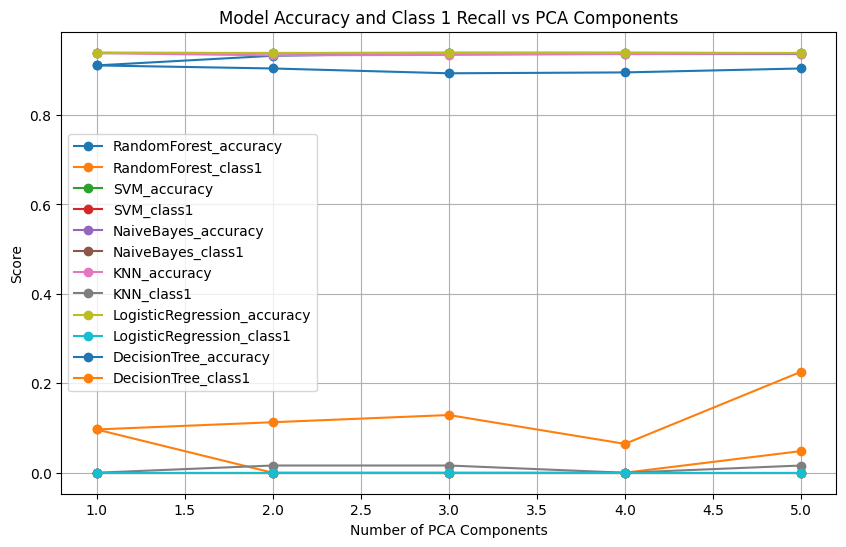

In [279]:
df_results, top_3_models = run_stroke_model_analysis(df_stroke, target_col='stroke', max_components=5)
